----------------------------------
   # Case Study:    Twitter US Airline Sentiment
----------------------------------

## Context: 

- Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.
- That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.
- Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.
- In this case study we will build a sentiment classification model by using a sentiment analysis job that was done about the problems of each major U.S. airline where Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service")

## Probelm:

- Explore and visualize the dataset.
- Perform text pre-processing.
- Transform the unstructred data to structrued data via:
    - Bag of words vectorization
    - Tf-idf vectorization
- Come up with an optimized classification model to predict the sentiment of a tweet.

## Dataset
- The dataset has the following columns:
    * tweet_id                                                           
    * airline_sentiment                                               
    * airline_sentiment_confidence                               
    * negativereason                                                   
    * negativereason_confidence                                    
    * airline                                                                    
    * airline_sentiment_gold                                              
    * name     
    * negativereason_gold 
    * retweet_count
    * text
    * tweet_coord
    * tweet_created
    * tweet_location 
    * user_timezone

## Importing necessary libraries

In [1]:
# Importing library to help in suppressing the warnings
import warnings

warnings.filterwarnings("ignore")

# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# To supress numerical display in scientific notations
pd.set_option("display.float_format", lambda x: "%5f" % x)
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# Sets the limit for the column width
pd.set_option("max_colwidth", 240)

# Libraries to help with data visualization
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

sns.set(color_codes=True)


# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
)

# Importing the library for huperparameters tuning
from sklearn.model_selection import GridSearchCV

# Importing XGBClassfier
from xgboost import XGBClassifier

# Importing libraries to treat special characters( re:  regular expression engine and unicodedata to treat accented characters)
import re, string, unicodedata

# Natural language processing tool-kit
import nltk

# !pip install contractions
# Importing library to de-contract words
import contractions

# Beautiful soup is a parsing library that can use different parsers.
from bs4 import BeautifulSoup

# Importing libraries for tokenization
from nltk import word_tokenize, sent_tokenize

# Stopwords, and wordnet corpus
from nltk.corpus import stopwords, wordnet

# Importing the library for lemmatization
from nltk.stem import WordNetLemmatizer

# Importing libraries to plot word cloud graph
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Importing libraries for vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# To get reproducable results
from numpy.random import seed

seed(1)

<IPython.core.display.Javascript object>

 ## Loading the data

In [2]:
# Reading in the Dataset
dfTweetsOriginal = pd.read_csv("Tweets.csv")
# Making a copy of data
dfTweets = dfTweetsOriginal.copy()
# Printing the shape
print(dfTweets.shape)
# Getting an overall information about the dataset
dfTweets.info()
# View 10 sample rows of the dataset
dfTweets.sample(10)

(14640, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  ob

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
8515,568198336651649027,positive,1.000000,NaN,nan,Delta,NaN,GenuineJack,NaN,0,@JetBlue I'll pass along the advice. You guys rock!!,NaN,2015-02-18 16:00:14 -0800,Massachusetts,Central Time (US & Canada)
3439,568438094652956673,negative,0.703600,Lost Luggage,0.703600,United,NaN,vina_love,NaN,0,@united I sent you a dm with my file reference number.. I just want to know if someone has located my bag even if it's not here yet.,NaN,2015-02-19 07:52:57 -0800,ny,Quito
6439,567858373527470080,positive,1.000000,NaN,nan,Southwest,NaN,Capt_Smirk,NaN,0,@SouthwestAir Black History Commercial is really sweet. Well done.,NaN,2015-02-17 17:29:21 -0800,La Florida,Eastern Time (US & Canada)
5112,569336871853170688,negative,1.000000,Late Flight,1.000000,Southwest,NaN,scoobydoo9749,NaN,0,@SouthwestAir why am I still in Baltimore?! @delta is doing laps around us and laughing about it. # ridiculous,"[39.1848041, -76.6787131]",2015-02-21 19:24:22 -0800,"Tallahassee, FL",America/Chicago
5645,568839199773732864,positive,0.683200,NaN,nan,Southwest,NaN,laurafall,NaN,0,@SouthwestAir SEA to DEN. South Sound Volleyball team on its way! http://t.co/tN5cXCld6M,NaN,2015-02-20 10:26:48 -0800,NaN,Pacific Time (US & Canada)
1380,569748884164988929,negative,1.000000,Flight Attendant Complaints,0.681800,United,NaN,JacquieMae08,NaN,1,@united One of your workers refused to give me her name as a reference for my notes. Her tone &amp; language was very unprofessional.,NaN,2015-02-22 22:41:34 -0800,SD || CA,Arizona
12674,570066226233417728,negative,1.000000,Bad Flight,0.696600,American,NaN,lczand,NaN,0,@AmericanAir seats that were assigned are inappropriate for child this age. AA knew age of child.,NaN,2015-02-23 19:42:34 -0800,SE USA,Central Time (US & Canada)
13475,569853969469734912,negative,1.000000,Customer Service Issue,0.364200,American,NaN,Davitossss,NaN,0,@AmericanAir now you change my gate and don't tell me? What the fuck is wrong with you people. Learn to do your fucken job,NaN,2015-02-23 05:39:08 -0800,NaN,NaN
9630,569771270839013376,negative,1.000000,Late Flight,1.000000,US Airways,NaN,jakenemmasmom,NaN,0,@USAirways What a mess caused by the computer systems. Flight 719 in 3 hours Late Flight and now no gate for us. Est 26 min wait.,NaN,2015-02-23 00:10:31 -0800,NaN,NaN
3745,568157451729526784,negative,1.000000,Customer Service Issue,0.680300,United,NaN,HeHaithMe,NaN,1,"@united How come you are the ONLY airline, of 90+ flights last year that makes me check my carry-on. Not even gate check...baggage claim?!?",NaN,2015-02-18 13:17:47 -0800,Born/Raised in 314/Home is 317,Eastern Time (US & Canada)


<IPython.core.display.Javascript object>

**Observations**
- There are 14640 observations\rows and 15 columns\features.
- The target variable is airline_sentiment.
- Columns negativereason,negativereason_confidence,airline_sentiment_gold,negativereason_gold,tweet_coord,tweet_location, and user_timezone have missing values.

## Exploratory Data Analysis

### Checking for duplicates

In [3]:
print(f" Cardinality of tweet_id feature: {dfTweets.tweet_id.nunique()} ")

 Cardinality of tweet_id feature: 14485 


<IPython.core.display.Javascript object>

**Observations**
- There are duplicated tweets IDs, since we have 14640 0bservations\rows ans 14485 unique tweet_id let's see if these are real duplicated tweets or a typo in the tweet ID

### Analyzing the duplicates

In [4]:
# Getting the counts of tweets ids, transforing the series into data frame with index as the tweet_id
tweets_id_count = dfTweets.tweet_id.value_counts().to_frame()
# Getting a list of tweets_id of duplicated tweets
duplicatedbyindex = tweets_id_count[tweets_id_count.tweet_id > 1].index
# Getting the duplicated tweets in dfTweets for analysis
dfTweets.loc[dfTweets.tweet_id.isin(duplicatedbyindex)].sort_values("tweet_id")

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12033,569600137296633856,positive,0.923600,NaN,0.000000,American,positive,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30 -0800,"Caribbean, New York and Miami.",Indiana (East)
14556,569600137296633856,positive,1.000000,NaN,nan,American,NaN,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30 -0800,"Caribbean, New York and Miami.",Indiana (East)
14543,569601363799359488,negative,1.000000,Flight Attendant Complaints,1.000000,American,NaN,stevereasnors,NaN,0,@AmericanAir should reconsider #usairways acquisition. Flight 1843 AA gold flyers insulted by attendant for hanging jacket!,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)
12032,569601363799359488,negative,0.955300,Flight Attendant Complaints,0.955300,American,negative,stevereasnors,Flight Attendant Complaints,0,@AmericanAir should reconsider #usairways acquisition. Flight 1843 AA gold flyers insulted by attendant for hanging jacket!,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)
12031,569621879633391616,negative,1.000000,Customer Service Issue,1.000000,American,negative,salitron78,Customer Service Issue,0,@AmericanAir no response to DM or email yet. customer service?,NaN,2015-02-22 14:16:53 -0800,on @TheJR,Seoul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12042,570307949614256128,negative,1.000000,Can't Tell,1.000000,American,NaN,ELLLORRAC,NaN,0,@AmericanAir thanks for getting back to me. But I will find other airlines in the future.,NaN,2015-02-24 11:43:05 -0800,NaN,Central Time (US & Canada)
11880,570308064185880577,neutral,0.666700,NaN,nan,American,NaN,LancasterPattie,NaN,0,@AmericanAir we've already made other arrangements ourselves.,NaN,2015-02-24 11:43:32 -0800,NaN,NaN
12041,570308064185880577,neutral,0.675500,NaN,0.000000,American,NaN,LancasterPattie,NaN,0,@AmericanAir we've already made other arrangements ourselves.,NaN,2015-02-24 11:43:32 -0800,NaN,NaN
12040,570308309682675712,negative,1.000000,Customer Service Issue,1.000000,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I even consider continuing your point program when I received no perks or continued bad customer service? #senseless,NaN,2015-02-24 11:44:31 -0800,NaN,Quito


<IPython.core.display.Javascript object>

**Observations**
- We can clearly observe that these are duplicated tweets, since beside the duplicated tweet_id other columns such as time_created, tweet_location, name, and the text of the tweets are identical for the duplicated tweet_id.
- Let's go ahead and remove the duplicates.

In [5]:
# Removing duplicate tweets
dfTweets.drop_duplicates("tweet_id", inplace=True)
# Checking if the removal was successful
print(f" Cardinality of tweet ID feature: {dfTweets.tweet_id.nunique()} ")
dfTweets.tweet_id.value_counts()

 Cardinality of tweet ID feature: 14485 


569969218306904067    1
569976622054395904    1
568604899870711808    1
569273375954243584    1
570100214733737985    1
                     ..
568417260668379136    1
567907070269198337    1
569015379021795328    1
569683872046194688    1
570074833993670657    1
Name: tweet_id, Length: 14485, dtype: int64

<IPython.core.display.Javascript object>

**Observations**
- Duplicated tweets were succsefully removed.

In [6]:
# Function to add the percentage of each class of the category
def perc_on_bar(plot, feature):
    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=12)  # annotate the percantage

<IPython.core.display.Javascript object>

 ### Plotting the distribution of all tweets by airline

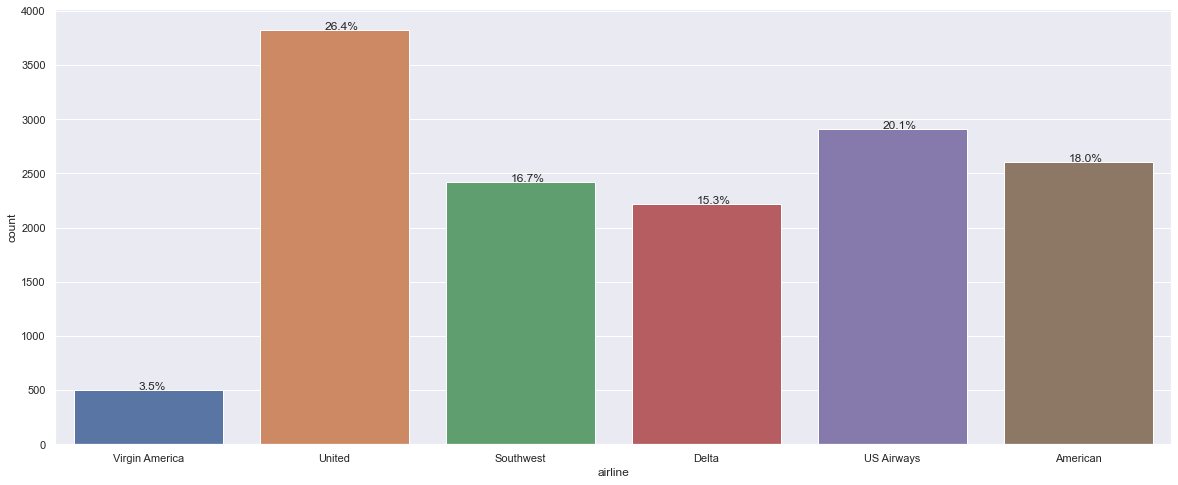

<IPython.core.display.Javascript object>

In [7]:
plt.figure(figsize=(20, 8))
ax = sns.countplot(data=dfTweets, x="airline")
perc_on_bar(ax, dfTweets)

**Observations**
- The highest tweets count was for United with 26.4% of the tweets, then US Airways with 20.1%, then American with 18%, then southwest with 16.7%, then Delta with 15.3%, and the least count of tweets was for Virgin America with just 3.5% of the tweets.

### Plotting the distribution of sentiment across all the tweets

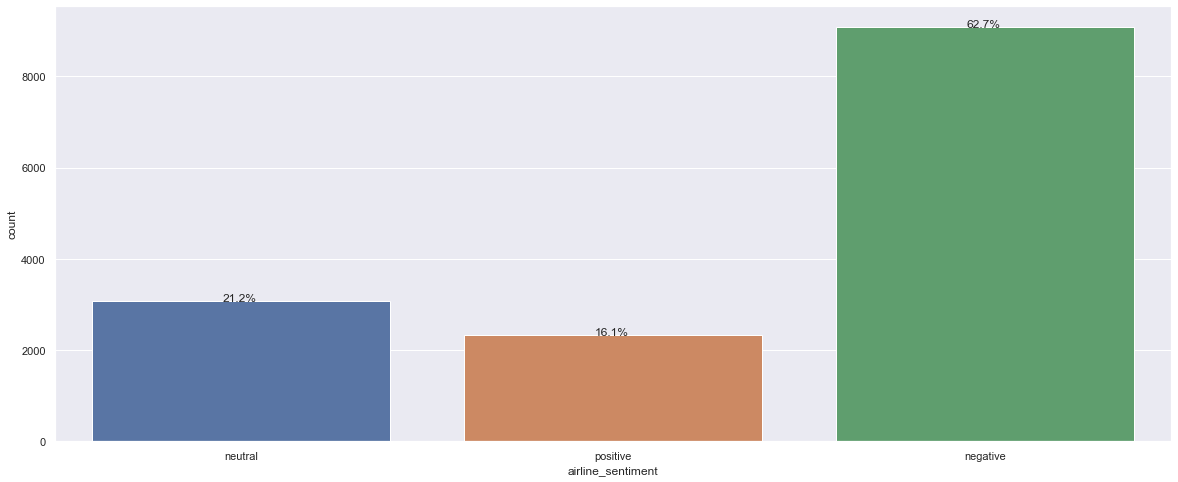

<IPython.core.display.Javascript object>

In [8]:
plt.figure(figsize=(20, 8))
ax = sns.countplot(data=dfTweets, x="airline_sentiment")
perc_on_bar(ax, dfTweets)

**Observations**
- The majority of the tweets(62.7%) were with a negative sentiment, then neutral sentiment with 21.2% of the tweets comes second, then only 16.1% of the tweets were with positive sentiment which third.
- The target have three different classes: negative, neutral, and positive, therefore we are dealing with a multiclass sentiment analysis\classification task.

### Plotting the distribution of Sentiment of tweets for each airline 

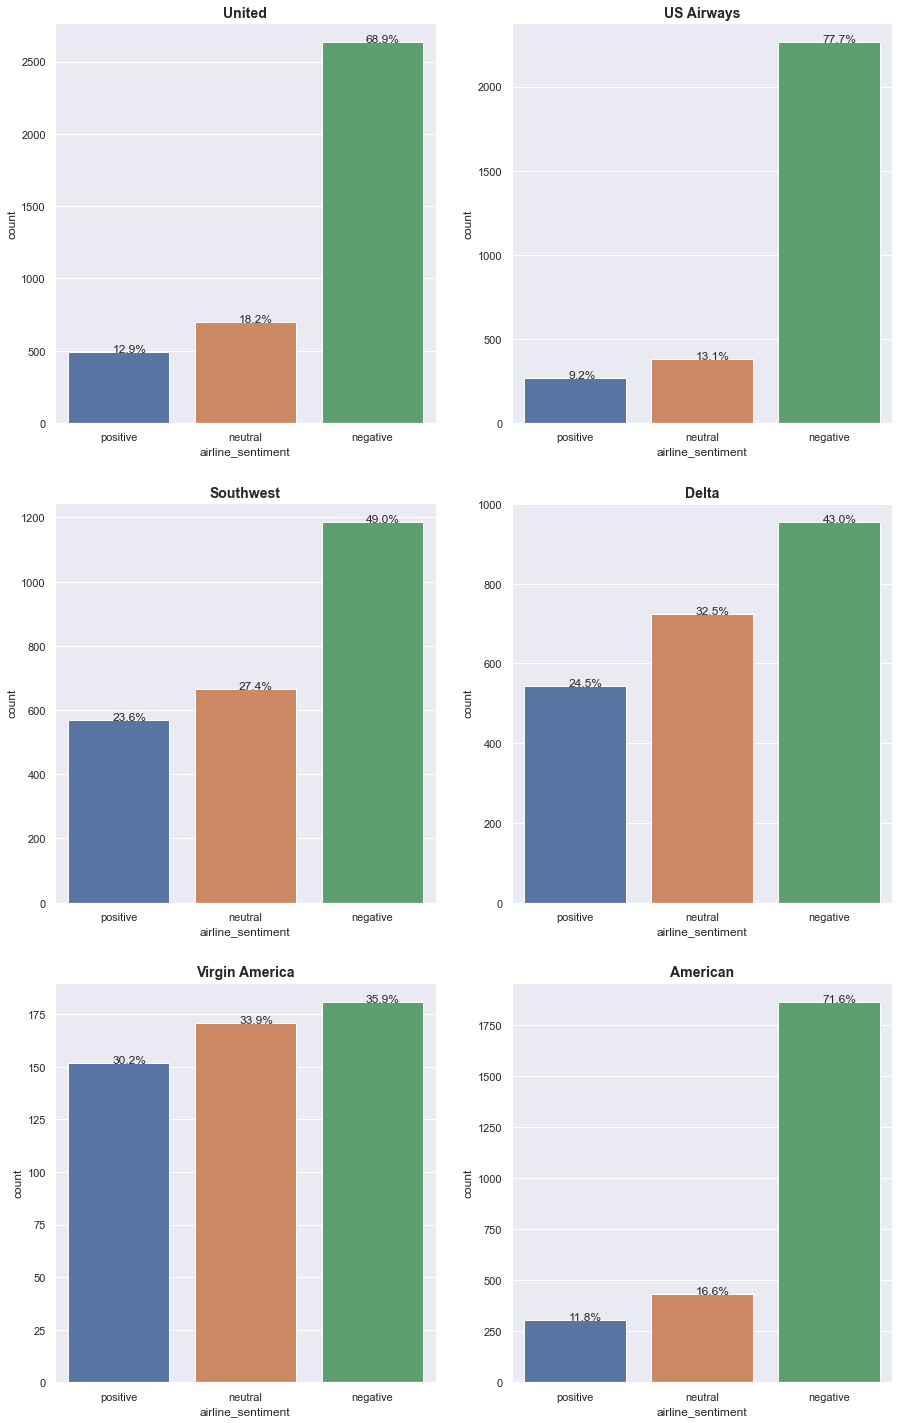

<IPython.core.display.Javascript object>

In [9]:
airlines = ["United", "US Airways", "Southwest", "Delta", "Virgin America", "American"]
fig, axes = plt.subplots(3, 2, figsize=(15, 25))
# A plot with 3 rows and 2 columns, both zero indexed.
# Row i and Column j represented by axes[i,j] will represnt one boxplot

for i in range(len(airlines)):
    ax = sns.countplot(
        ax=axes[int(i / 2), i % 2],
        order=["positive", "neutral", "negative"],
        data=dfTweets[dfTweets.airline == airlines[i]],
        x="airline_sentiment",
    )
    perc_on_bar(ax, dfTweets[dfTweets.airline == airlines[i]])
    ax.set_title(airlines[i], fontsize=14, fontweight="bold")
plt.show()

**Observations**
- For United 68.9% of the tweets were negative, 18.2% of the tweets were neutral, and 12.9% were positive.
- For US Airways 77.7% of the tweets were negative, 13.1% of the tweets were neutral, and 9.2% were positive.
- For Southwest 49% of the tweets were negative, 27.6% of the tweets were neutral, and 23.4% were positive.
- For Delta 43% of the tweets were negative, 32.5% of the tweets were neutral, and 24.5% were positive.
- For Virgin America 35.9% of the tweets were negative, 33.9% of the tweets were neutral, and 30.2% were positive.
- For American 71.6% of the tweets were negative, 16.6% of the tweets were neutral, and 11.8% were positive.
- Based on the above airline_sentiment distribution we can observe that:
    - The customers of US Airways had the highest percentage for negative tweets and the lowest for positive tweets. 
    - The customers of Virgin America had the highest percentage for positive tweets and the lowest for negative tweets.
    - Accross all airlines US Airways customers are the least satisfied, then America customers, then United customers.
    - Accross all airlines Virgin America customers are the most satisfied customers, then Delta customers, then Southwest customers.

### plotting the distribution of all the negative reasons

In [10]:
# From earlier analysis negativereason column have missing values, this can be expected for poisitve and neutral tweets,
# let's check that
dfTweets[
    dfTweets.negativereason.notna()
].airline_sentiment.to_frame().airline_sentiment.value_counts()

negative    9082
Name: airline_sentiment, dtype: int64

<IPython.core.display.Javascript object>

**Observations**
- As expected, negativereason is not null only for negative tweets(tweets where airline_sentiment=negative)

In [11]:
# Replacing missing value with "Not Applicable"  for positive and neutral tweets.
dfTweets["negativereason"] = dfTweets["negativereason"].fillna("Not Applicable")

<IPython.core.display.Javascript object>

In [12]:
# Checking if the replacement was successful
dfTweets.negativereason.value_counts(dropna=False)

Not Applicable                 5403
Customer Service Issue         2885
Late Flight                    1650
Can't Tell                     1176
Cancelled Flight                829
Lost Luggage                    719
Bad Flight                      575
Flight Booking Problems         523
Flight Attendant Complaints     475
longlines                       177
Damaged Luggage                  73
Name: negativereason, dtype: int64

<IPython.core.display.Javascript object>

**Obsservations**
- The missing values for negativereason were replaced with "Not Applicable" for the positive and neutral tweets. 

plot of the distribution of all the negative reasons

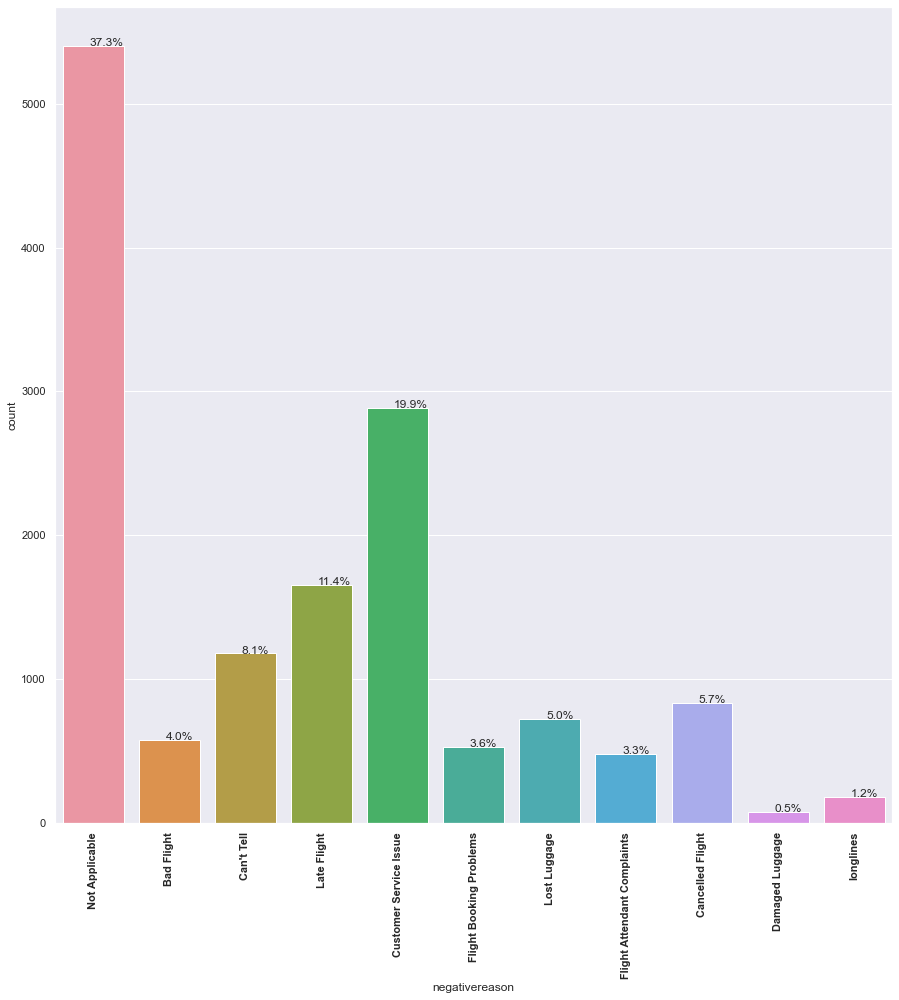

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(15, 15))
ax = sns.countplot(data=dfTweets, x="negativereason")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight="bold")
perc_on_bar(ax, dfTweets)

**Observations**
- As expected 37.3% of the tweets(neutral and positive) have None for negative reason(21.2% neutral + 16.1% positive = 37.3%)
- The leading reason for the negative tweets sentiment is the Customer Service Issue which represents 19.9% of all the tweets, then comes the Late Flight with 11.4% of all the tweets. 
- The least reason for the negative tweets sentiment is Damaged Luggage with 0.5% of all the tweets, then the longlines with 1.2% of all the tweets
- **Let's plot the distribution of negativereason only for tweets with airline_sentiment of negative value. Since negative reason is applicable\makes sense only for negative sentiment tweets and not for positive or neutral tweets as explained earlier.**

#### Plotting the negative reason distribution only for negative tweets.

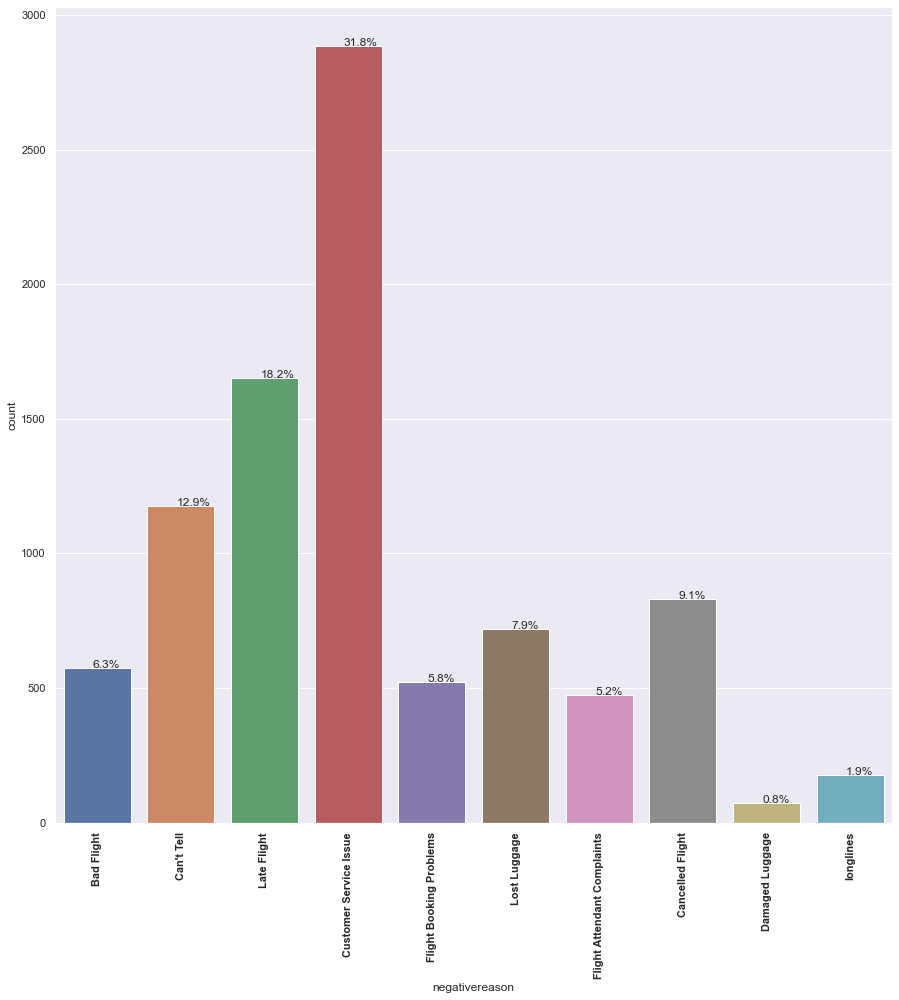

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(15, 15))
ax = sns.countplot(
    data=dfTweets.loc[dfTweets.airline_sentiment == "negative"], x="negativereason"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight="bold")
perc_on_bar(ax, dfTweets.loc[dfTweets.airline_sentiment == "negative"])

**Observations**
- The top negativereason is Customer Service Issue which represents 31.8% of the reasons of the negative tweets, then Late Flight with 18.2% of the negative tweets, then 12.9% of the customers negative tweets refused to give the reason, then Cancelled Flight with 9.1% of the negative tweets, then Lost Luggage with 7.9% the negative tweets, then Bad Flight with 6.3% of the negative tweets, then Flight Booking Problemes with 5.5% of the negative tweets, then Flight Attendant Complaints with 5.2% of the negative tweets, then longlines with 1.9% of the negative tweets, then Damaged Luggage whith 0.8% of the negative tweets. 

### Plotting Tweets  Word Cloud Graph 
- The size and the boldness of the word is in function of its frequency in the tweets(positive correlation).
- Words that are more frequent in the tweets will be bigger in size and bolder. 

In [15]:
# Function to plot a world cloud graph
def show_wordcloud(sentiment, title):
    text = " ".join(
        dfTweets.loc[dfTweets.airline_sentiment == sentiment, "text"]
        .astype(str)
        .tolist()
    )
    stopwords = set(STOPWORDS)
    fig_wordcloud = WordCloud(
        stopwords=stopwords,
        background_color="white",
        colormap="viridis",
        width=800,
        height=600,
    ).generate(text)
    plt.figure(figsize=(14, 11), frameon=True)
    plt.imshow(fig_wordcloud)
    plt.axis("off")
    plt.title(title, fontsize=30)
    plt.show()

<IPython.core.display.Javascript object>

#### Plotting the positive tweets sentiment word cloud graph

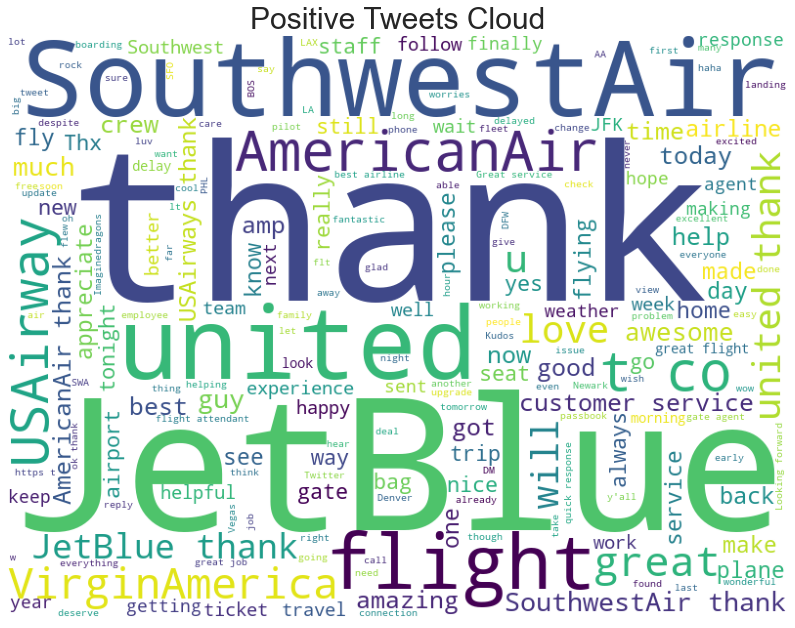

<IPython.core.display.Javascript object>

In [16]:
show_wordcloud("positive", "Positive Tweets Cloud")

**Observations**
- A lot of the words in the text column are positive sentiment in nature such as Thank(the most hoghlighted word), great, amazing, awesome, fantastic, love,good
-  All the airline names are highlighted, "JetBlue" then "SouthwestAir" are bigger in size and bolder than the rest which means that they are the most airline names mentioned in the positive tweets indicating a better customers satisfaction for these two airlines than the rest.
- From earlier analysis VirginAmerica had the highest percentage of positive tweets, however United with the least percentage of positive tweets among all airlines is bigger and bolder than VirginAmerica, this can be explained by low count of tweets for VirginAmerica(only 3.5% of the tweets were for VirginAmerica compared with 26.4% for united)

#### Plotting the negative tweets sentiment word cloud graph

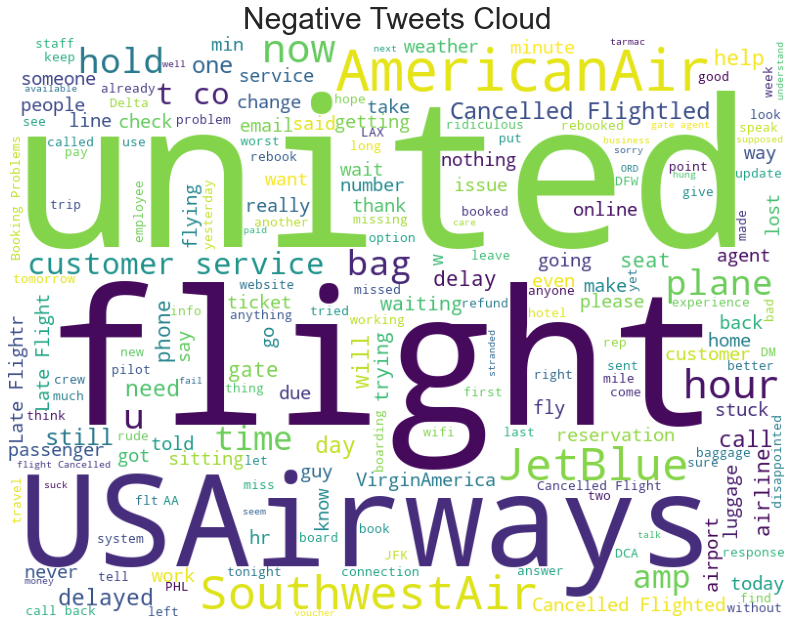

<IPython.core.display.Javascript object>

In [17]:
show_wordcloud("negative", "Negative Tweets Cloud")

**Observations**
- A lot of the words in the text column are negative sentiment in nature such as Cancelled, Late,delayed, waiting, booking problems, ridiculous, worst,...
-  All the airline names are highlighted with "United" then "USAAirways" are bigger and bolder than the rest which means they are the most airline names mentioned in the negative tweets tweets indicating thye lowest customers satisfaction for these two airlines than the rest.
- From both tweets sentiment word cloud graph:
    - The presence of VirginAmerica in the positive cloud and its abscence in the negative cloud. This confirms the earlier finding where the customers of Virgin America had the highest percentage of postive tweets and the lowest percentage of negative tweets.  
    - We can note the presence of JetBlue word and the abscence of Delta word in both clouds. Let's check 4 sample tweets from each airline for further analysis.

### Analyzing 4 sample tweets from each airline

In [18]:
for aline in airlines:
    print(dfTweets.loc[dfTweets.airline==aline, ['airline','text']].sample(4))


     airline  \
4081  United   
3315  United   
2286  United   
831   United   

                                                                                                                                            text  
4081  @united $7 for wifi just so I can tell my family I'm gonna be Late Flight cause i had to sit in a grounded plane for the past two hours...  
3315                                                           @united can I access Frankfurt arrival lounge when I'm flying global first class?  
2286                                                                @united hey, I missed my outbound flight - can I still use my return ticket?  
831            @united UA276 sitting at EWR nearly an hour after sked.  Pilot says computers down but no clue when we will leave.  Can you help?  
          airline  \
11497  US Airways   
10975  US Airways   
9161   US Airways   
9515   US Airways   

                                                                              

<IPython.core.display.Javascript object>

**Observations**
- We can observe that some tweets have HTTP links, we should remove them from the tweets text.
- We also observe that each tweet start with @airlinename, however for Delta the tweets text starts with @JetBlue. 
    - This could be explained by a typo in the airline column, where instead of JetBlue, Delta was entered. Plus Delta is one of the major and biggest Air Lines in the world and its share of tweets from the dataset doesn't much that(5th among all six airlines). Therefore the given reason makes more sense than being a typo in the tweet text(typo of @JetBlue instead of @Delta) 
    - This also explains the presence of JetBlue word in the tweets sentiment word cloud graph and the abscence of Delta word.

### Conclusion and Insights
- The highest tweets count was for United with 26.4% of the tweets,the lowest count of tweets was for Virgin America with just 3.5% of the tweets.
- The majority of the tweets(62.7%) were with a negative sentiment, then comes second neutral sentiment with 21.2% of the tweets, then only 16.1% of the tweets were with positive sentiment.
- Accross all airlines and from the tweets sentiment analysis by airline, US Airways customers are the least satisfied, then America customers, then United customers.
- Accross all airlines and from the tweets sentiment analysis by airline Virgin America customers are the most satisfied customers, then JetBlue customers, then Southwest customers.
- From the negative reasons analysis and in order to improve the customers satisfaction and therefore improve the bussnines the airlines should:
    1. Improve its customer service which the leading reason given in the negative sentiment tweets(about third of the negative tweets mentioned this reason for being a negative sentiment tweet).
    2. Try to be more punctual since Late Flight reason is the second highest percentage reason given in the negattive tweets.
    3. If a flight is canceled then the airline shoud offer incentives such as discounts in the next flight to aleviate the frustration of its customers. Cancelled flight is the third highest percentage of the negative reasons. 
    4. The airlines should improve its lagguage handling since Lost Luggage is in the top 5 reasons given in the negative tweets.
    5. The airlines should improve the flights condition for example by offering better beverages and snacks, since Bad Flight is also in the top reasons given in the negative tweets.


### Dropping all columns except airline_sentiment and text

In [19]:
# Dropping all columns except airline_sentiment and text
dfTweets.drop(
    dfTweets.columns.difference(["airline_sentiment", "text"]), axis=1, inplace=True
)
# Checking the shape of the data
print(dfTweets.shape)
# Printing the first 5 rows of the data
dfTweets.head(5)

(14485, 2)


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


<IPython.core.display.Javascript object>

**Observations**
- The dataset have now 14485 observations\rows and two columns 'text' and 'airline_sentiment.
- 'airline_sentiment' is the target as mentioned earlier and our text columns and after pre-processing will be used to generate the structured data to be used for modeling.

## Text pre-processing

- Text preprocessing is a method to clean the text data and make it ready to feed data to the model. Text data contains noise in various forms like emotions, punctuation, special characters which are non-required items.
- It also helps in reducing the dimension and therefore the complexity of our model.
- We will perform the following in our Text pre-processing:
    - 1. Removal HTML tags and HTTp links.
    - 2. De-contraction of words
    - 3. Tokenization.
    - 4. Removal of numbers.
    - 5. Removal of Special Characters and Punctuations.
    - 6. Removal of stopwords
    - 7. Conversion to lowercase.
    - 8. Lemmatization.
    - 9. Joining the words in the list to convert back to text string in the data frame. (So that each row
          contains the data in text format.)

### 1.1 HTML Tag Removal

In [20]:
# function to remove html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


# Applying the function on the 'text' column of the dataset
dfTweets["text"] = dfTweets["text"].apply(lambda x: strip_html(x))
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
8702,positive,@JetBlue Finally taking off! LAS-FLL-SJU #letsgo
6242,negative,@SouthwestAir it's the poor customer service that I have a problem with!!!!!
4998,neutral,"@SouthwestAir BTW, not a weather delay. We've had beautiful weather in Sunny California. #nolove #noexcuses #cali http://t.co/kumtbgER03"
3570,negative,@united it's not there we tried. It's already here in cancun just no one has delivered it
8598,positive,@JetBlue thanks. Line moved quick. Already done.


<IPython.core.display.Javascript object>

**Observations**
- From the displayed rows we don't see html tags in the text column

### 1.2 HTTP Link Removal

In [21]:
# Removal of the http link using Regular Expression.
for i, row in dfTweets.iterrows():
    clean_tweet = re.sub(r"http\S+", "", dfTweets.at[i, "text"])
    dfTweets.at[i, "text"] = clean_tweet
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
5168,negative,.@SouthwestAir I finally hung up after 2 hours and was not able to get the flight I needed. #stuckintampa 😞
4609,positive,@SouthwestAir thank you!
8502,negative,@JetBlue C'mon now. My flight's delayed annnnnd you can't give me a pick?!? I'm about to tweet at @united or @Delta .......
7237,negative,"@JetBlue Yes, I filed yesterday around noon. I have a claim number but they haven't contacted me yet."
3235,negative,@united over an hour stuck and still not off the plane. Total failure by you and your partners in ensuring the best customer experience.


<IPython.core.display.Javascript object>

**Observations**
- From the displayed rows we don't see http links in the text column

### 2. De-contraction of words
- While not mandatory to do at this stage prior to tokenization but:
    - Replacing contractions with their expansions can be beneficial at this point, since our word tokenizer will split words like "didn't" into "did" and "n't."
    - It's not impossible to remedy this tokenization at a later stage, but doing so prior makes it easier and more straightforward.

In [22]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)


# Applying the function on the 'text' column of the dataset
dfTweets["text"] = dfTweets["text"].apply(lambda x: replace_contractions(x))
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
6723,positive,"@SouthwestAir Beautiful, thanks a ton!"
12913,negative,@AmericanAir instead they yelled at him and told him to call a number that will not pick up due to call volume
6285,neutral,@SouthwestAir goes to court to gain access to @Delta gates at Love Field #deltanews
2334,negative,"@united what, you forgot to tell them the flight was coming... Thanks for allowing me to miss my connection"
11686,negative,"@USAirways And really, it is a middle initial versus middle name. All else the same. Not spending my time on your computer issues."


<IPython.core.display.Javascript object>

**Observations**
- From the displayed rows we don't see contracted words in the text column

### 3.Tokenization

In [23]:
# Tokenization of data
dfTweets["text"] = dfTweets.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1)
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
8047,neutral,"[@, JetBlue, I, did, ...., Would, be, nice, to, see, more, services, out, of, @, triflight, instead, of, having, to, drive, 3-4, hrs, to, like, charlotte, or, atlanta]"
13902,negative,"[@, americanair, Any, hints, to, get, through, to, and, stay, connected, with, you, to, rearrange, weather, reLate, Flightd, Cancelled, Flights, ?, Hours, in, now, w/nothing, .]"
11589,negative,"[@, USAirways, that, link, leads, to, a, website, that, will, not, open, on, a, cell, phone, ., Good, job, ,, shocking, that, your, airline, is, folding, .]"
12348,negative,"[@, AmericanAir, your, staff, at, rsw, working, the, sliver, airlines, desk, is, not, helpful, ., We, can, not, get, any, information, about, our, flight, .]"
11759,negative,"[@, USAirways, your, customer, service, stinks, ., Trying, to, book, a, flight, for, hours, now, and, keep, getting, hung, up, on, ., #, usairwayssucks]"


<IPython.core.display.Javascript object>

**Observations**
- The text of the tweet was tokenized into a list of tokens(individual words)

### 4. Removal of Numbers

In [24]:
def remove_numbers(words):
    new_words = []  # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r"\d+", "", word)
        if new_word != "":
            new_words.append(new_word)  # Append processed words to new list.
    return new_words


# Applying the function on the 'text' column of the dataset
dfTweets["text"] = dfTweets["text"].apply(lambda x: remove_numbers(x))
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
4049,negative,"[@, united, it, was, an, international, flight, ,, and, we, did, not, get, our, new, eta, until, we, were, in, the, air, .]"
7887,positive,"[@, JetBlue, @, Airbus, Wow, what, an, amazing, video, Great, world, Guys, #, Bluemanity, #, CoreValues, #, Passion, #, AeroJobMarket]"
14028,negative,"[@, americanair, seriously, ,, pls, pls, bring, more, people, up, to, help, us, !, There, are, still, flights, to, ORD, frm, DFW, and, I, want, in]"
14534,negative,"[., @, AmericanAir, I, can, not, even, get, on, the, phone, with, your, reservations, team, ., The, system, automatically, disconnects, us, .]"
5975,negative,"[@, SouthwestAir, I, already, follow, you, and, can, not, DM, because, you, need, to, follow, me, back]"


<IPython.core.display.Javascript object>

**Observations**
- From the displayed rows we don't numbers in the text column.

### 5.Removal of Special Characters including non-ASCII Characters and Punctuations.

In [25]:
def remove_special_characters_and_punctuation(words):
    """Remove non-ASCII characters from list of tokenized words"""
    # Create empty list to store pre-processed words.
    new_words = []
    for word in words:
        # Converting non-ascii charcaters to ascii ones
        new_word = (
            unicodedata.normalize("NFKD", word)
            .encode("ascii", "ignore")
            .decode("utf-8", "ignore")
        )
        # Removal of special characters and Punctuations using regex
        new_word = re.sub(r"[^\w\s]", "", new_word)
        # Append processed words to new list if not empty
        if new_word != "":
            new_words.append(new_word)
    return new_words


# Applying the function on the 'text' column of the dataset
dfTweets["text"] = dfTweets["text"].apply(
    lambda x: remove_special_characters_and_punctuation(x)
)
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
6053,neutral,"[SouthwestAir, when, is, the, next, deal, going, to, happen, a, poor, college, student, is, trying, to, fly, to, Orlando, instead, of, drive, in, August, Lol]"
8651,negative,"[it, is, on, me, JetBlue, that, is, not, what, you, said, last, night, though]"
1008,negative,"[united, UnitedAirlines, Pls, Fix, AspenBaggageFail, issues, Had, to, pay, my, own, way, to, Aspen, after, flight, Cancelled, Flight, Left, us, in, the, cold, in, DEN]"
14138,negative,"[AmericanAir, I, understand, flight, Cancelled, Flightation, but, not, being, able, to, get, through, to, change, that, flight, for, hrs, is, not, acceptable]"
6978,neutral,"[JetBlue, hi, guys, do, you, have, a, general, enquires, email, address, please, Thanks, David]"


<IPython.core.display.Javascript object>

**Observations**
- Special characters as @ were removed.

### 6.Removal of stopwords

In [26]:
stopwords = stopwords.words("english")

customlist = [
    "not",
    "didn",
    "doesn",
    "hadn",
    "hasn",
    "haven",
    "isn",
    "ma",
    "mightn",
    "mustn",
    "ain",
    "aren",
    "couldn",
    "didn",
    "doesn",
    "needn",
    "shan",
    "shan't",
    "shouldn",
    "wasn",
    "weren",
    "won",
    "wouldn",
]

# Set custom stop-word's list as not, didn etc(no need to include didn't etc since we decontracted the words.
# these words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words


# Applying the function on the 'text' column of the dataset
dfTweets["text"] = dfTweets["text"].apply(lambda x: remove_stopwords(x))
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
11270,neutral,"[USAirways, AnnetteNaif, We, appreciate, shoutout, Roberto, DM, confirmation, code, forward, kind, words, sent]"
7701,negative,"[JetBlue, Complete, waste, entire, day, Pathetic]"
4952,negative,"[SouthwestAir, worst, air, line, ever, compassion, handicapped]"
8655,positive,"[JetBlue, thanks]"
6841,negative,"[JetBlue, Flight, delayed, Buffalo, direct, flight, plane, gate]"


<IPython.core.display.Javascript object>

**Observations**
- From the 5 displayed samples we don't see stop words in the text column.

### 7.Conversion to Lowercase

In [27]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


# Applying the function on the 'text' column of the dataset
dfTweets["text"] = dfTweets["text"].apply(lambda x: to_lowercase(x))
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
12669,neutral,"[americanair, usairways, i, need, cancelled, flight, flight, i, booked, earlier, tonight, are, able, twitter]"
13437,negative,"[americanair, i, like, call, back, system, but, thought, would, like, know, not, working, well, i, received, three, calls, audio]"
7687,neutral,"[jetblue, i, i, land]"
9419,negative,"[usairways, seat, d, flight, last, night, worst, seat, i, ever, no, leg, room, dividendsmember]"
13074,negative,"[americanair, no, had, cancelled, flight, trip, instead, future, trip, voucher, drink, coupon, would, better, wakinginmemphis]"


<IPython.core.display.Javascript object>

**Observations**
- Characters are in a lowercase format in the text column

### 8.Lemmatization
- Lemmatization on the surface is very similar to stemming, where the goal is to remove inflections and map a word to its root form.
- The only difference is that, lemmatization tries to do it the proper way. It doesn’t just chop things off, it actually transforms words to the actual root. For example, the word “better” would map to “good”.
- It may not be possible manually provide the corrent POS tag for every word. So, instead, we will find out the correct POS tag for each word, map it to the right input character that the WordnetLemmatizer accepts and pass it as the second argument to lemmatize(). This approach gave me a better model generalization and accuracy than just setting POS tag to 'v'

In [28]:
# nltk.download('averaged_perceptron_tagger')

# Function to get the POS tag for a given word
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }
    return tag_dict.get(tag, wordnet.NOUN)


# Initiate Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to Lemmatize with the appropriate POS tag, this approach gave me a better model generalization and accuracy score
# At first I tried setting pos to 'v'.
def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
    return new_words


# Applying lemmatize_list function on the 'text' column of the dataset
dfTweets["text"] = dfTweets["text"].apply(lambda x: lemmatize_list(x))
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
10376,negative,"[usairways, i, change, flight, hour, crazy, please, help]"
12008,negative,"[americanair, misunderstood, usairways, would, not, day, flight, change, the, gate, agent, say, no]"
11391,negative,"[usairways, strike, lose, bag, and, two, theworst]"
8272,neutral,"[jetblue, i, want, enter, family, pool, contest, say, website, i, please, enter, still]"
13115,negative,"[americanair, ewr, dfw, stop, bna, refuel, bad, weather, be, you, try, get, plane, closer, dfw, cancel, flight, u]"


<IPython.core.display.Javascript object>

**Observations**
- From the displayed samples we only see lemmas.

### 9. Joining the words in the list to convert back to text string in the data frame

In [29]:
# Function to convert the list of words into a text string
def joining(words):
    return " ".join(words)


# Applying the function on the 'text' column of the dataset
dfTweets["text"] = dfTweets["text"].apply(lambda x: joining(x))
# Display 5 sample rows from the dataset
dfTweets.sample(5)

,airline_sentiment,text
3902,positive,united cool thanks
10554,negative,usairways ridiculous clt miss connect flight chuckhole runway shameful
2982,negative,united bad head laguardia delayed why tray table size mouse pad overhead size pocket
12290,neutral,americanair not yet i plan if could fly low slow right front would great
6196,negative,southwestair good know now three set traveler min stand wait min pas


<IPython.core.display.Javascript object>

**Observations**
- The list of words were successuly transformed to text string.

### Printing the first 5 rows of data after the pre-processing.

In [30]:
dfTweets.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus add commercial experience tacky
2,neutral,virginamerica i not today must mean i need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guest face little recourse
4,negative,virginamerica really big bad thing


<IPython.core.display.Javascript object>

**Observations**
- Our dataset is cleaned and normalized and its ready to be vectorized(transformed to real numbers) so we can feed it to our ML model

## Vectorization
- Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers.
- We will use two techniques:
    - 1. Count Vectorizer: creates a document-term matrix containing the count(int) of word occurrences in the document
    - 2. Term Frequency(TF)-Inverse Document Frequency(IDF) Vectorizer:  weighs words by the frequency of appearance within a document(Tf) but penalizes words that appear across many documents(IDF).Therefore it will creates a document-term matrix contining TF*IDF(float) of each word

### 1. Count Vectorizer

In [31]:
# Keep only 1000 features as number of features will increase the processing time.
bow_vec = CountVectorizer(max_features=1000) 
# Learn vocabulary and word occurence  and return document-term matrix.
data_features_bow = bow_vec.fit_transform(dfTweets['text'])
# Converting to np array
data_features_bow = data_features_bow.toarray()  
# Printing the shape.
data_features_bow.shape


(14485, 1000)

<IPython.core.display.Javascript object>

** Observations**
- Our dataset will have 14485 observations(rows) with 1000 features(words). 
- This dataset data_features_bow will be used when building our first sentiment classification model.

###  2. Term Frequency(TF) - Inverse Document Frequency(IDF) Vectorizer

In [32]:
# Keep only 1000 features as number of features will increase the processing time.
tfidf_vec = TfidfVectorizer(max_features=1000)
# Learn vocabulary,TF, and IDF  and return document-term matrix .
data_features_tfidf = tfidf_vec.fit_transform(dfTweets["text"])
# Converting to np array
data_features_tfidf = data_features_tfidf.toarray()
# Printing the shape.
data_features_tfidf.shape

(14485, 1000)

<IPython.core.display.Javascript object>

** Observations**
- Our dataset will have 14485 observations(rows) with 1000 features(columns). 
- This dataset data_features_tfidf will be used when building our second sentiment classification model.

## **Models Building, Tunning, and Evaluation**

- We will use XGBClassifier to build our sentiment classification model.
- In this case study we are dealing with a multi-classification task(three classes) therefore we nedd to set the following XGBClassifier parameters:
    - 1. objective="multi:softmax" 
    - 2. num_class=3, 
    - 3.eval_metric="mlogloss"
- We will use two datasets:
    - 1. data_features_bow where the features were generated by Count Vectorizer technique
    - 2. data_features_tfidf where the features were generated by TF_IDF Vectorizer technique


### Model evaluation criterion
- Our metric of model evaluation will be accuracy, however we will calculate other metrics score to monitor overfitting for all metrics
- Let's define function to provide metric scores(accuracy,recall,precision and f1-score) on train and test set and a function to show confusion matrix so that we do not have use the same code repetitively while evaluating models.**

In [33]:
##  Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and F1-score
def get_metrics_score(model, train, test, train_y, test_y, flag=True):

    # defining an empty list to store train and test results
    score_list = []

    pred_train = model.predict(train)
    pred_test = model.predict(test)

    train_acc = model.score(train, train_y)
    test_acc = model.score(test, test_y)

    train_recall = recall_score(train_y, pred_train, average="macro")
    test_recall = recall_score(test_y, pred_test, average="macro")

    train_precision = precision_score(train_y, pred_train, average="macro")
    test_precision = precision_score(test_y, pred_test, average="macro")

    train_f1 = f1_score(y_train, pred_train, average="macro")
    test_f1 = f1_score(y_test, pred_test, average="macro")

    score_list.extend(
        (
            train_acc,
            test_acc,
            train_recall,
            test_recall,
            train_precision,
            test_precision,
            train_f1,
            test_f1,
        )
    )

    # If the flag is set to True then only the following print statements will be displayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ", model.score(train, train_y))
        print("Accuracy on test set : ", model.score(test, test_y))
        print(
            "Recall on training set : ",
            recall_score(train_y, pred_train, average="macro"),
        )
        print(
            "Recall on test set : ",
            recall_score(test_y, pred_test, average="macro"),
        )
        print(
            "Precision on training set : ",
            precision_score(train_y, pred_train, average="macro"),
        )
        print(
            "Precision on test set : ",
            precision_score(test_y, pred_test, average="macro"),
        )
        print(
            "F1-Score on training set : ",
            f1_score(y_train, pred_train, average="macro"),
        )
        print("F1-Score on test set : ", f1_score(y_test, pred_test, average="macro"))

    return score_list  # returning the list with train and test scores

<IPython.core.display.Javascript object>

In [34]:
## Function to create confusion matrix
def make_confusion_matrix(model, y_actual, labels=["negative", "neutral", "positive"]):
    """
    model : classifier to predict values of X
    y_actual : ground truth

    """
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(
        y_actual, y_predict, labels=["negative", "neutral", "positive"]
    )
    df_cm = pd.DataFrame(
        cm,
        index=[
            i for i in ["Actual - negative", "Actual - neutral", "Actual - positive"]
        ],
        columns=[
            i
            for i in [
                "Predicted - negative",
                "Predicted - neutral",
                "Predicted - positive",
            ]
        ],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(3, 3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt="")
    plt.ylabel("True Sentiment")
    plt.xlabel("Predicted Sentiment")

<IPython.core.display.Javascript object>

###  1. Building XGBClassifier using Count Vectorizer

### Splitting the dataset into train and test sets

In [35]:
# the dependent variable\Target
y = dfTweets["airline_sentiment"]
# Split X and y into train and test sets in 80:20 ratio, stratify=y:to ensure that relative class frequencies are approximately
# preserved in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data_features_bow, y, test_size=0.2, stratify=y, random_state=42
)

<IPython.core.display.Javascript object>

### Building and Fitting intial Model

In [36]:
# Building the XGBClassifier model
xgb_bow = XGBClassifier(
    random_state=1, objective="multi:softmax", num_class=3, eval_metric="mlogloss"
)
# Fitting the model to the train dataset
xgb_bow = xgb_bow.fit(X_train, y_train)

<IPython.core.display.Javascript object>

###  Model Evaluation

Accuracy on training set :  0.8463928201587849
Accuracy on test set :  0.7797721781152916
Recall on training set :  0.7738255285798138
Recall on test set :  0.6789513146861755
Precision on training set :  0.8218428183088727
Precision on test set :  0.7371970217947229
F1-Score on training set :  0.7948502753402451
F1-Score on test set :  0.7024241144367046


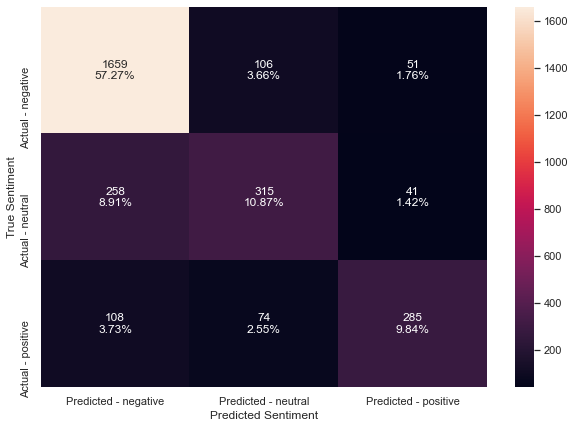

<IPython.core.display.Javascript object>

In [37]:
# Getting the metric scores
get_metrics_score(xgb_bow, X_train, X_test, y_train, y_test)
# Creating confusion matrix
make_confusion_matrix(xgb_bow, y_test)

**Observations**
- The model achieved an accuracy score of 77.97% on test set.
- The model is overfitting the training data. There is a notable difference between Train and Test for all the metrics.
- Let's try to improve the model by tuning the hyperparameters using the Grid Search technique to get the optimum values

### Tuning xgb_bow model using GridSearch

In [38]:
# Choose the type of classifier.
xgb_bow_tuned = XGBClassifier(
    random_state=1, objective="multi:softmax", num_class=3, eval_metric="mlogloss"
)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [30, 70],
    "subsample": [0.8],
    # "learning_rate": [0.08],
    # "colsample_bytree": [0.5],
    "colsample_bylevel": [0.8],
    "max_depth": [3, 5],
    "gamma": [7],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_bow_tuned, parameters, scoring=scorer, n_jobs=-1, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifer to the best combination of parameters
xgb_bow_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_bow_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=7, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=70, n_jobs=4, num_class=3,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

####  Model Evaluation

Accuracy on training set :  0.7683810838798757
Accuracy on test set :  0.762858129099068
Recall on training set :  0.648298222241857
Recall on test set :  0.6355839839730897
Precision on training set :  0.7298784183260288
Precision on test set :  0.7257794623858601
F1-Score on training set :  0.6759625126646402
F1-Score on test set :  0.6655878118537218


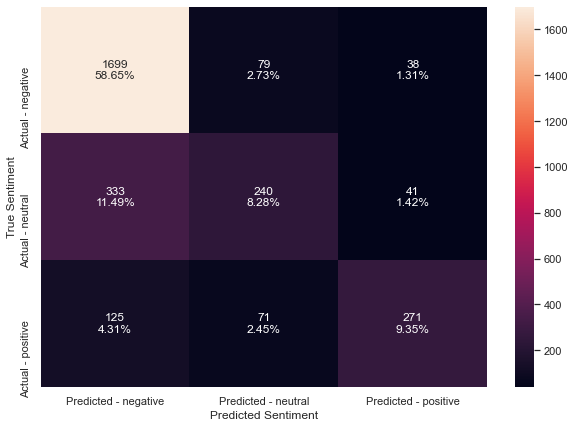

<IPython.core.display.Javascript object>

In [39]:
# Getting the metrics scores
get_metrics_score(xgb_bow_tuned, X_train, X_test, y_train, y_test)
# Creating confusion matrix
make_confusion_matrix(xgb_bow_tuned, y_test)

**Observations** 
- The model achieved an accuracy of 76.28% on test set.
- The model generalized well metrics scores for train and test sets are very comparable and very close.

### Printing the top 40 features and plotting their word cloud

*********************** Top 40 features **********************
1 . thank
2 . thanks
3 . not
4 . usairways
5 . hour
6 . united
7 . great
8 . southwestair
9 . fleek
10 . americanair
11 . jetblue
12 . best
13 . amaze
14 . love
15 . customer
16 . cancel
17 . virginamerica
18 . bad
19 . bag
20 . awesome
21 . hr
22 . hold
23 . delayed
24 . wait
25 . good
26 . destinationdragons
27 . call
28 . dm
29 . lose
30 . min
31 . thx
32 . service
33 . phone
34 . ceo
35 . delay
36 . try
37 . luggage
38 . appreciate
39 . one
40 . rock


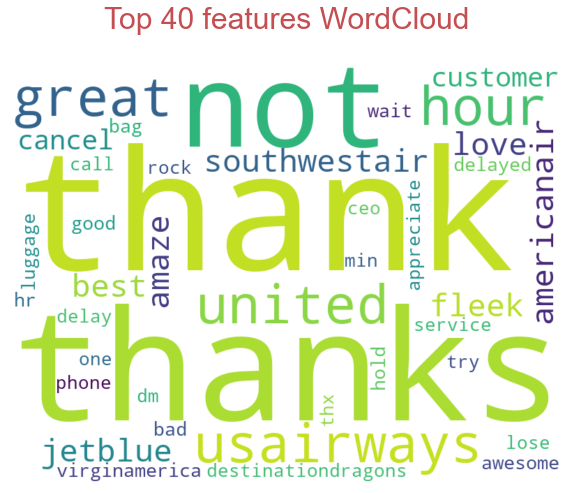

<IPython.core.display.Javascript object>

In [40]:
# Getting all feaures from the vectorizer
all_features = bow_vec.get_feature_names()
top_features = ""
# Getting features importance after training xgb_bow_tuned model
feat = xgb_bow_tuned.feature_importances_
# Sorting features by importance
features = np.argsort(feat)[::-1]
# Addition of top 40 features into top_feature
for i in features[0:40]:
    top_features += all_features[i]
    top_features += " "
# Printing the top 40 features in descending order with regard to importance value, the feature with the highest importance
# will be printed fist with a rank of 1.
print("*********************** Top 40 features **********************")
top_list = list(top_features.split(" "))
for i in range(0, 40):
    print(i + 1, ".", top_list[i])
## Generating the word cloud graph for the top 40 features, here we set normalize_plurals to Fasle so for example thank(the verb) and
# and thanks(noun) will show seperatly in the word clud graph.
wordcloud = WordCloud(
    stopwords=stopwords,
    normalize_plurals=False,
    background_color="white",
    colormap="viridis",
    width=800,
    height=600,
).generate(top_features)
# Display the generated image
plt.figure(1, figsize=(10, 10), frameon="equal")
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Top 40 features WordCloud\n", fontsize=30, color="r")
plt.axis("off")
plt.show()

**Observations**
- The top 40 features were printed in descending order with regard to importance, the feature with the highest importance(here thank) had a rank of 1.
- We can observe thank(verb) and thanks(noun) as first and second top features. This due to the approach taken in lemmatization (Lemmatizer with appropriate POS tag) which gave me a better model generalization and accuracy score as explained earlier.
- We can clearly observe that the word cloud graph reflects the top features importance, where the size and boldness of the word increases as the importance of the feature increases. 

### 2. Building XGBClassifier  Using  **Term Frequency(TF) - Inverse Document Frequency(IDF)**

### Splitting the dataset into train and test sets

In [41]:
# The dependent variable\Target
y = dfTweets["airline_sentiment"]
# Split X and y into train and test sets in 80:20 ratio, stratify=y:to ensure that relative class frequencies are approximately
# preserved in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data_features_tfidf, y, test_size=0.2, stratify=y, random_state=1
)

<IPython.core.display.Javascript object>

### Building and Fitting intial Model

In [42]:
# Building the XGBClassifier model
xgb_tfidf = XGBClassifier(
    random_state=1, objective="multi:softmax", num_class=3, eval_metric="mlogloss"
)
# Fitting the model to the train dataset
xgb_tfidf = xgb_tfidf.fit(X_train, y_train)

<IPython.core.display.Javascript object>

###  Model Evaluation

Accuracy on training set :  0.8704694511563686
Accuracy on test set :  0.7918536416983086
Recall on training set :  0.802637449656055
Recall on test set :  0.6912432539453429
Precision on training set :  0.8614900721483995
Precision on test set :  0.7550612378566545
F1-Score on training set :  0.8280842786813256
F1-Score on test set :  0.7163994175722656


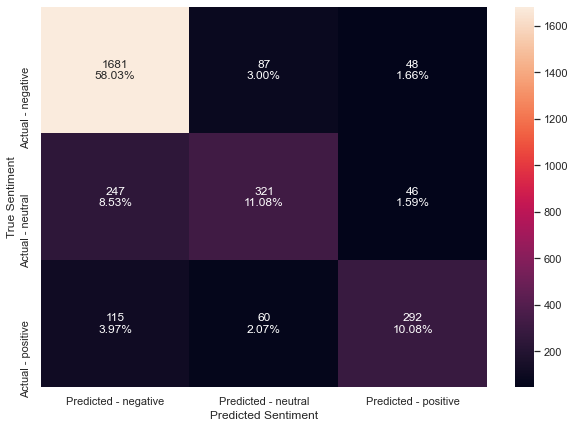

<IPython.core.display.Javascript object>

In [43]:
# Getting the metrics scores
get_metrics_score(xgb_tfidf, X_train, X_test, y_train, y_test)
# Creating confusion matrix
make_confusion_matrix(xgb_tfidf, y_test)

**Observations**
- The model achieved an accuracy of 79.18% on test set.
- The model is overfitting the training data. There is a notable difference between Train and Test for all the metrics scores.
- Let's try to improve the model by tuning the hyperparameters using the Grid Search technique to get the optimum values.

### Tuning xgb_tfidf model using GridSearch

In [44]:
# Choose the type of classifier.
xgb_tfidf_tuned = XGBClassifier(
    random_state=1, objective="multi:softmax", num_class=3, eval_metric="mlogloss"
)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [40, 80],
    "subsample": [0.8],
    # "learning_rate": [0.08],
    # "colsample_bytree": [0.5],
    "colsample_bylevel": [0.8],
    "max_depth": [3, 5],
    "gamma": [7],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tfidf_tuned, parameters, scoring=scorer, n_jobs=-1, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifer to the best combination of parameters
xgb_tfidf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tfidf_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=7, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=4, num_class=3,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

###  Model Evaluation

Accuracy on training set :  0.7829651363479462
Accuracy on test set :  0.7759751467034863
Recall on training set :  0.6669764548090095
Recall on test set :  0.6572917379466962
Precision on training set :  0.7532643949871956
Precision on test set :  0.7458913394211514
F1-Score on training set :  0.698043376442591
F1-Score on test set :  0.6884343159492815


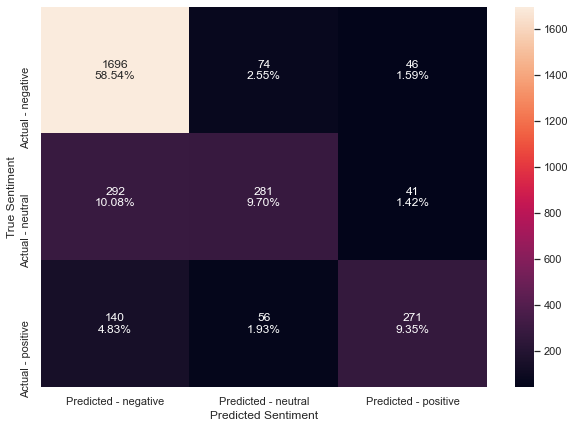

<IPython.core.display.Javascript object>

In [45]:
# Getting the metrics scores
get_metrics_score(xgb_tfidf_tuned, X_train, X_test, y_train, y_test)
# Creating confusion matrix
make_confusion_matrix(xgb_tfidf_tuned, y_test)

**Observations**
- The model achieved an accuracy of %77.6 on the test set.
- The model generalized very well, metrics scores' for train and test sets are very comparable and very close. 

### Printing the top 40 features and plotting their word cloud

*********************** Top 40 features **********************
1 . thank
2 . thanks
3 . not
4 . hour
5 . great
6 . usairways
7 . jetblue
8 . southwestair
9 . service
10 . love
11 . best
12 . united
13 . amaze
14 . cancel
15 . dm
16 . customer
17 . hold
18 . awesome
19 . delayed
20 . bad
21 . virginamerica
22 . fleet
23 . call
24 . kudos
25 . hr
26 . delay
27 . wait
28 . americanair
29 . min
30 . tomorrow
31 . bag
32 . hi
33 . fleek
34 . destinationdragons
35 . thx
36 . good
37 . lose
38 . appreciate
39 . minute
40 . miss


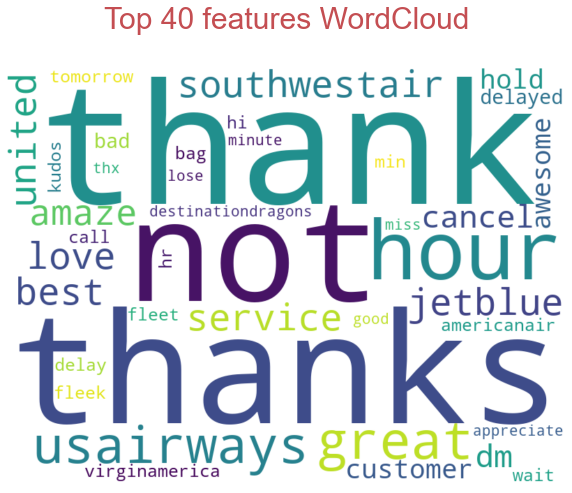

<IPython.core.display.Javascript object>

In [46]:
# Getting all feaures from the vectorizer
all_features = tfidf_vec.get_feature_names()
top_features = ""
# Getting features importance after training xgb_tfidf_tuned model
feat = xgb_tfidf_tuned.feature_importances_
# Sorting features by importance
features = np.argsort(feat)[::-1]
# Addition of top 40 feature into top_feature
for i in features[0:40]:
    top_features += all_features[i]
    top_features += " "
# Printing the top 40 features
print("*********************** Top 40 features **********************")
top_list = list(top_features.split(" "))
for i in range(0, 40):
    print(i + 1, ".", top_list[i])
# Generating the word cloud graph for the top 40 features, here we set normalize_plurals to Fasle so for example thank(the verb) and
# and thanks(noun) will show seperatly in the word clud graph.
wordcloud = WordCloud(
    stopwords=stopwords,
    normalize_plurals=False,
    background_color="white",
    colormap="viridis",
    width=800,
    height=600,
).generate(top_features)
# Display the generated image:
plt.figure(1, figsize=(10, 10), frameon="equal")
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Top 40 features WordCloud\n", fontsize=30, color="r")
plt.axis("off")
plt.show()

**Observations**
- The top 40 features were printed in descending order with regard to importance, the feature with the highest importance(here thank) had a rank of 1.
- We can observe thank(verb) and thanks(noun) as first and second top features. This due to the approach taken in lemmatization (Lemmatizer with appropriate POS tag) which gave me a better model generalization and accuracy score as explained earlier.
- We can clearly observe that the word cloud graph reflects the top features importance, where the size and boldness of the word increases as the importance of the feature increases. 

### **Summary**:

- We used a dataset which has **Tweets in text format and their sentiment: negative, or neutral, or positive**
- We performed an EDA on the data set like the distribution of tweets between the airlines, the distribution of negative reasons, the disribution of sentiments among all tweets, and also this distribution for each airline. Also we plotted the word cloud graph for the positive tweets, and negative tweets seperatly.
- We performed **Text pre-processing** for the text column, it is a method **to clean the text data and make it ready to be fed to the model**, by removing  noises like .htlm tags and http links,emotions, punctuation, special characters which are non-required items.
- **Text pre-processing* also helps in reducing the dimension and therefore the complexity of our model.**
- We performed the following in our Text pre-processing using various techniques and libraries.:
    - 1. Removal HTML tags and HTTp links.
    - 2. De-contraction of words like converting can't to can not
    - 3. Tokenization: It is the task of taking the tweet text and breaking it up into individual tokens
    - 4. Removal of numbers: Removed the numbers from the tokens, this will help dimensionality reduction. 
    - 5. Removal of Special Characters and Punctuations: Beside removing special charcters as @ and punctuations as ?, we handled accented characters to make sure that these characters are converted and standardized into ASCII characters since we are analyzing English language texts. This step will also help in dimensionality reduction. 
    - 6. Removal of stop words after customization of stopwords this will lower the dimensionality.
    - 7. Conversion to lowercase to reduce the dimension since if we don't IF and if for example will be treated as different words .
    - 8. Lemmatization by Converting inflections to root word or Lemma to lower the dimensionality
    - 9. Joining the words in the list to convert back to text string in the data frame. (So that each row
          contains the data in text format.)
- The **pre-processed data is converted to numbers via vectorization**, so that we can feed the data into the model.
    - In this step we used two techniques:
        - 1. Count Vectorizer: creates a document_term matrix containing the count(int) of word occurrences in the document
        - 2. Term Frequency(TF)-Inverse Document Frequency(IDF) Vectorizer:  weighs words by the frequency of appearance within a document(Tf) but penalizes words that appear across many documents(IDF).Therefore it will create a document-term matrix containing TF*IDF(float) of each word
- We trained XGBClassifer on tow different datasets one was generated using count Vectorizer the second dataset was generated using TF-IDF vectorizer.
- Both models were optimized using GridSearch to tune the hyperparameters. We were successsful in elimenating the overfitting problem for both models.
- We  printed the top 40 features and its word cloud graph for the two tuned\optimized models:xgb_bow_tuned and xgb_tfidf_tuned
- The tuned XGBClassifer on the dataset generated by TF-IDF vectorization:xgb_tfidf_tuned achieved the best performance where the model generalized very well accross all the metrics and achieved an accuracy score of 77.60% on the test set. Then comes second xgb_bow_tuned(The tuned XGBClassifer on the dataset generated by count vectorization) which achieved an accuracy score of 76.28% on the test set and also generalized very well accross all the metrics.